# Building Image and Video Datasets
In this notebook, we will be creating our datasets from which to perform a single-shot face classifier from images on videos. Thye subject matter: Brazilian Jiu Jitsu No Gi Worlds Championships in December 2023. 

The single reference images will come from professional winning photos of the athletes as posted on the IBJJF Facebook page. The source videos will be extracted from the IBJJF's public YouTube page.

We will use OpenCV's Haar Cascade classifier to detect faces and their locations using bounding boxes. 

Image & Video Datasets:
- Image dataset: podium photos from a major tournament for facial recognition
    - IBJJF Podium Pics from the 2023 No Gi Worlds Tournament https://www.facebook.com/media/set/?set=a.728657779287780&type=3
- Video dataset: Black Belt matches on IBJJF's YouTube channel
    - IBJJF YouTube Playlist https://www.youtube.com/watch?v=VZN9Di_Ou-c&list=PLndFOMjO-W278-AspLyh5IWGC7eNQmF4U

In [1]:
import os
# from pytube import Playlist, YouTube
import cv2
import numpy as np
import glob
from PIL import Image
from IPython.display import display
import pickle

### Manually Download Images 
Podium pics are on Facebook and since there are less than 20 iamges, we will manually download them and skip the Facebook API process. Link provided above.

### Download Videos

In [ ]:
# Path to save videos
save_path = r'../match_videos/'

# URL of the YouTube playlist --> IBJJF No Gi Worlds Playlist
playlist_url = 'https://www.youtube.com/watch?v=VZN9Di_Ou-c&list=PLndFOMjO-W278-AspLyh5IWGC7eNQmF4U'

# Use the PyTube library to extract the playlist
playlist = Playlist(playlist_url)

# Loop through each video in the playlist
for video in playlist.video_urls:
    try:
        # Use the PyTube library to extract the video
        yt = YouTube(video)
        # Get the highest resolution stream
        stream = yt.streams.get_highest_resolution()
        # Download the video
        stream.download(output_path=save_path)
        print(f"Downloaded: {yt.title}")
    except Exception as e:
        print(f"Error downloading {video}: {str(e)}")


In [ ]:
# Simple command line version for downloading an entire playlit
# pytube 'https://www.youtube.com/watch?v=VZN9Di_Ou-c&list=PLndFOMjO-W278-AspLyh5IWGC7eNQmF4U'

### Detect Faces

In [2]:
save_path = r'../podium_pics/'

# Create a list of image files and their paths 
image_files = glob.glob(save_path + '/*.jpg')
len(image_files)

19

In [6]:
# Visually inspect the image
# img = Image.open(image_files[0])
# display(img)

### Haar Cascade Classifier with OpenCV

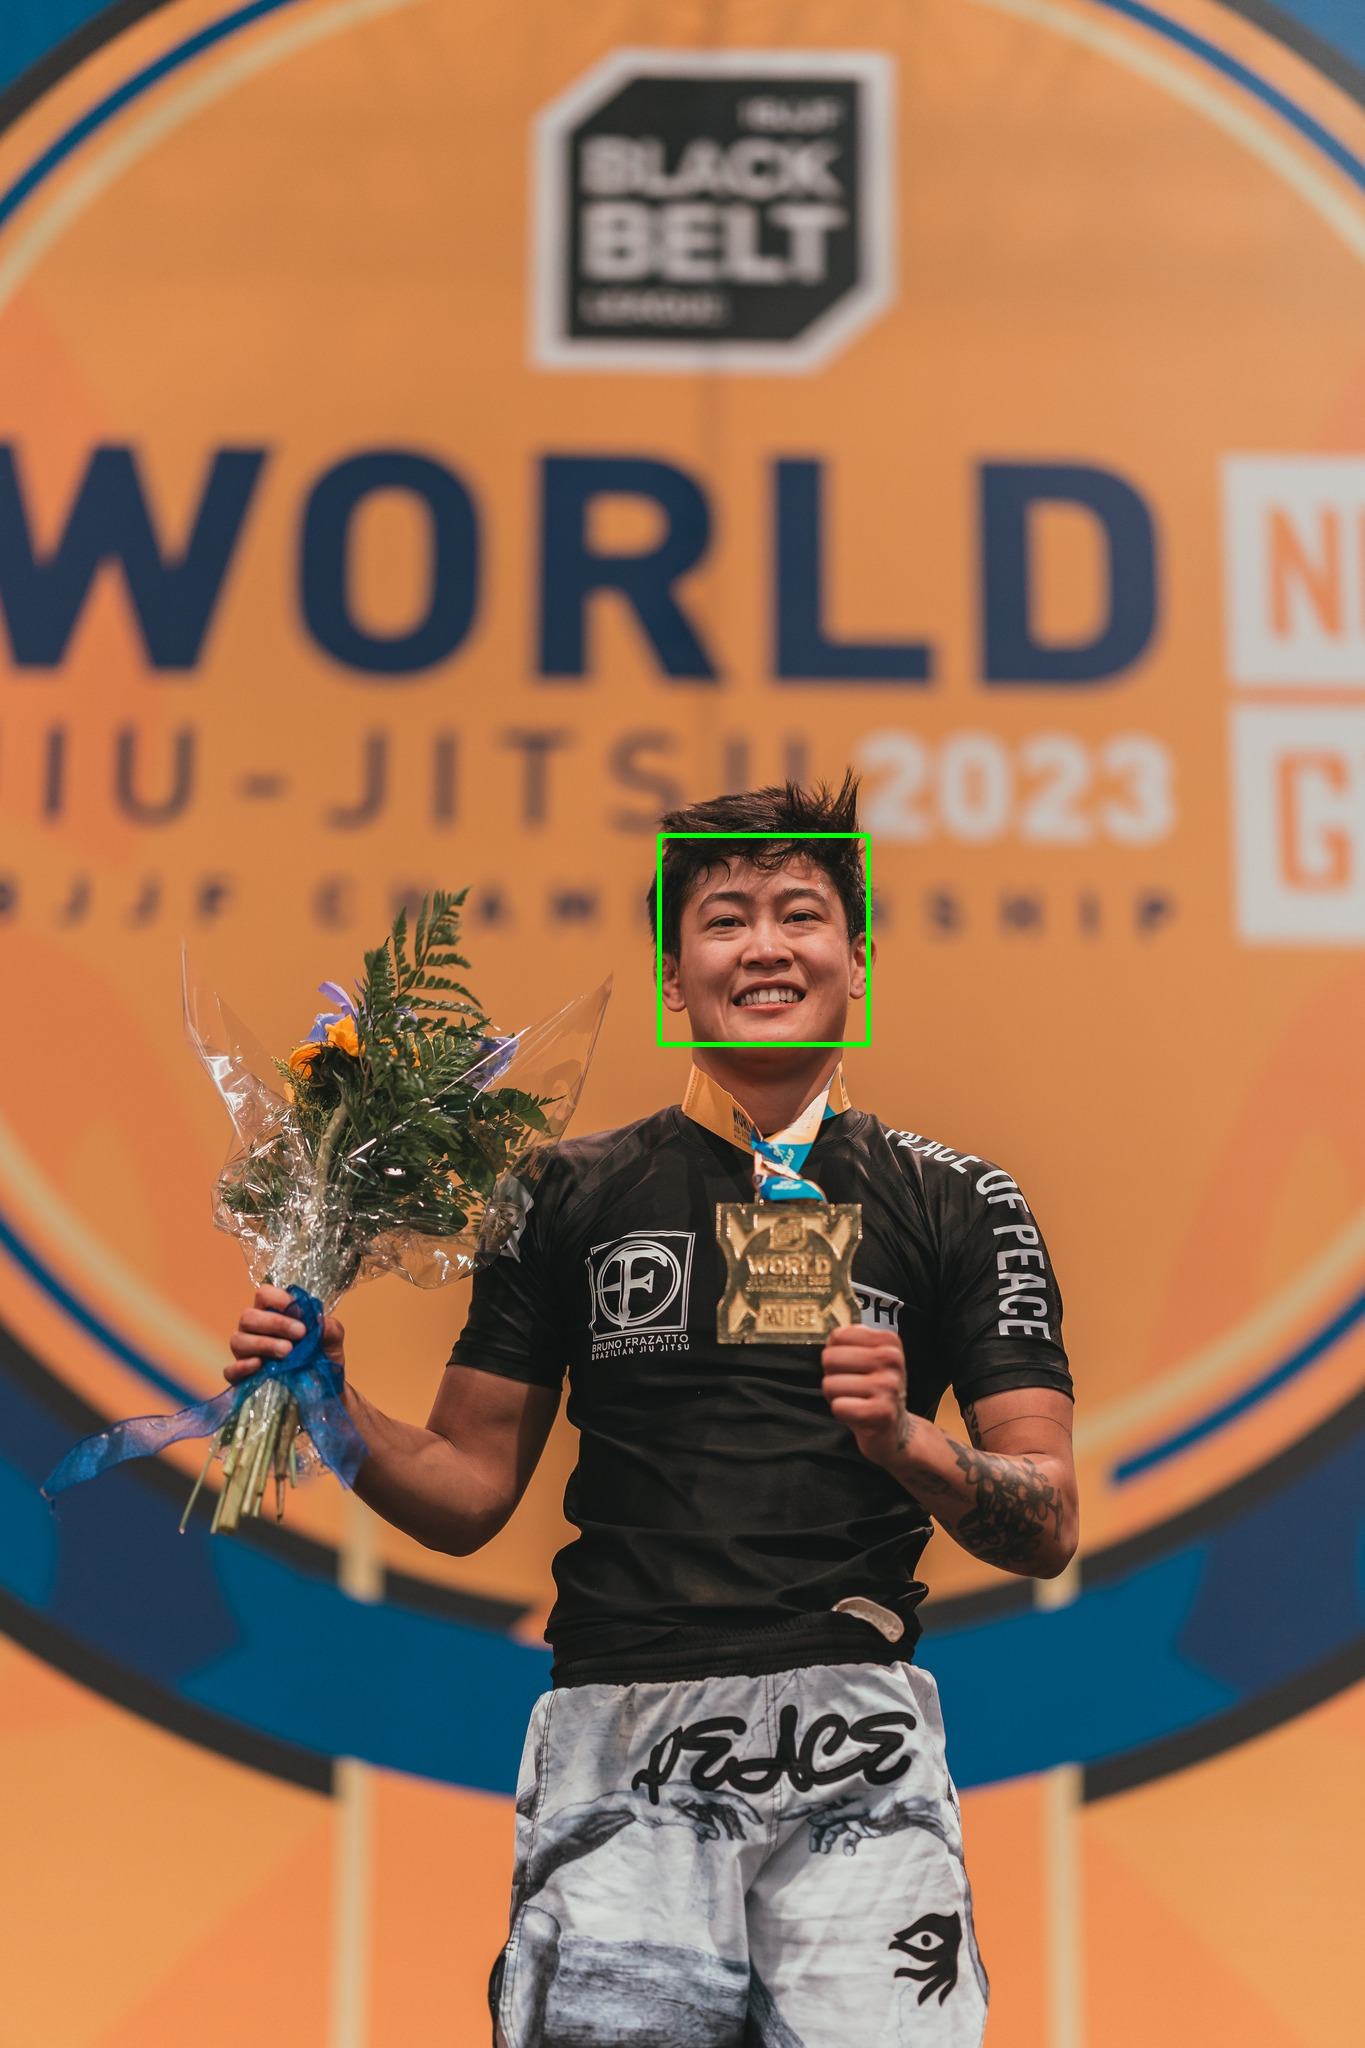

In [5]:
# Load a single image to test the face detector
img = cv2.imread(image_files[0])
rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Define the cascade classifier
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Detect faces, use higher scale factor to reduce false positives
faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5, minSize=(30, 30))

# Draw bounding boxes
for (x, y, w, h) in faces:
    cv2.rectangle(rgb_img, (x, y), (x + w, y + h), (0, 255, 0), 4)
    
pil_img = Image.fromarray(rgb_img)
display(pil_img)

In [9]:
def detect_faces(image):
    img = cv2.imread(image)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=6, minSize=(30, 30))
    return faces

face_dict = {}

for i in image_files:
    face_roi = detect_faces(i)
    file_name = os.path.basename(i)
    face_dict[file_name] = face_roi

face_dict    

{'409209567_728656402621251_7389117785980010295_n.jpg': array([[657, 832, 217, 217]], dtype=int32),
 '409188046_728657619287796_8447328742243697125_n.jpg': array([[505, 809, 176, 176]], dtype=int32),
 '410385148_728657419287816_1973964792862711750_n.jpg': array([[522, 597, 179, 179]], dtype=int32),
 '409211522_728656575954567_8251040193202394738_n.jpg': array([[601, 927, 161, 161]], dtype=int32),
 '410345998_728657745954450_5703997294672021240_n.jpg': (),
 '410480404_728657315954493_3236757987213521140_n.jpg': array([[600, 855, 129, 129]], dtype=int32),
 '410369238_728657245954500_4124320092528780961_n.jpg': array([[732, 898, 161, 161]], dtype=int32),
 '409206700_728656319287926_4900874984549400516_n.jpg': array([[625, 738, 194, 194]], dtype=int32),
 '410427281_728657192621172_5777001720576519417_n.jpg': array([[755, 991, 164, 164]], dtype=int32),
 '409203024_728656309287927_2576011051166713448_n.jpg': array([[657, 830, 163, 163]], dtype=int32),
 '409205260_728656365954588_451104889469

In [10]:
len(face_dict)

19

NOTE: Haar Cascade misses several faces or predicts multiple faces on images with only one person. It is a great start to face detection, but we will explore a deep learning model to clean up the errors.

### InsightFace
- https://github.com/deepinsight/insightface/tree/master/python-package

In [ ]:
# !pip3 install onnxruntime-gpu
# !pip3 install setuptools numpy cython
# !pip3 install insightface

In [7]:
import insightface
from insightface.app import FaceAnalysis
from insightface.data import get_image as ins_get_image

app = FaceAnalysis(providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])
app.prepare(ctx_id=0, det_size=(640, 640))

/home/neongreen13/.local/lib/python3.6/site-packages/requests/__init__.py:104: RequestsDependencyWarning: urllib3 (1.26.18) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  RequestsDependencyWarning)


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/neongreen13/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/neongreen13/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/neongreen13/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/neongreen13/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /home/neongreen13/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3,

In [8]:
save_path = "../podium_pics/face_detected/"

Test Image

/home/neongreen13/.local/lib/python3.6/site-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


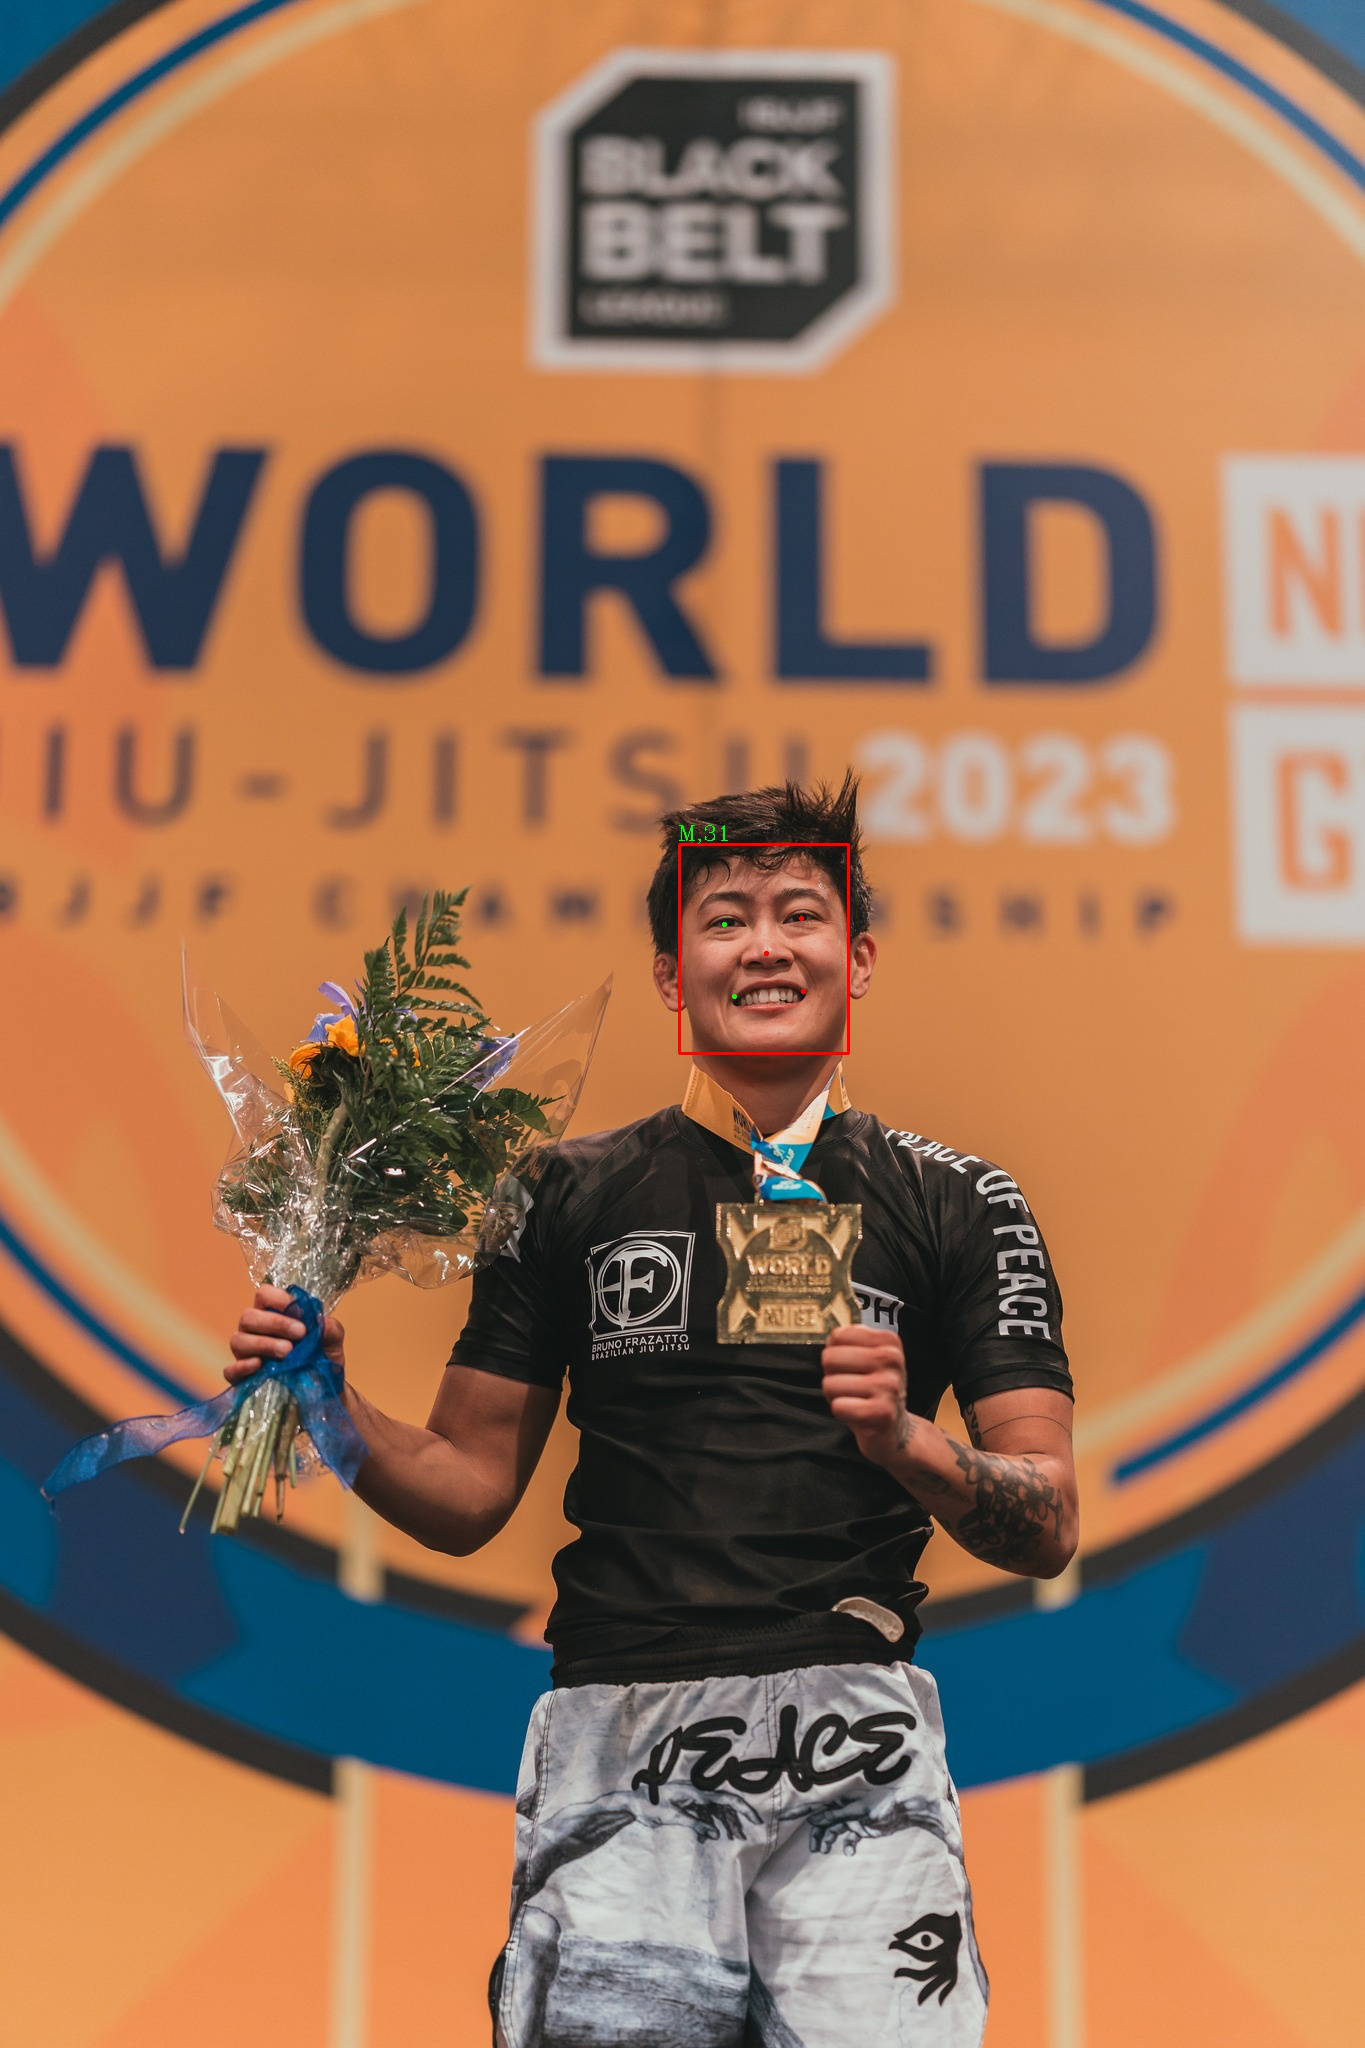

In [9]:
img_test = cv2.imread(image_files[0])
faces = app.get(img_test)
rimg = app.draw_on(img_test, faces)
# cv2.imwrite(save_path + "test_output.jpg", rimg)

img = Image.open(save_path + "test_output.jpg")
display(img)

In [10]:
face_dict_insight = {}

for idx,image_path in enumerate(image_files, start=1):
    img = cv2.imread(image_path)
    faces = app.get(img)
    rimg = app.draw_on(img, faces)
    output_filename = f"{save_path}insightface_{idx}.jpg"
    cv2.imwrite(output_filename, rimg)
    
    face_info = faces[0]
    
    bbox = face_info['bbox']
    det_score = face_info['det_score']
    gender = face_info['gender']    
    age = face_info['age']    
    
    
    file_name = os.path.basename(image_path)
    face_dict_insight[file_name] = {
        'bbox': bbox,
        'det_score': det_score,
        'gender': gender,
        'age': age,
    }

In [20]:
# Examine dict item
list(face_dict_insight.items())[0]

('409209567_728656402621251_7389117785980010295_n.jpg',
 {'bbox': array([ 679.1083 ,  844.19366,  848.2526 , 1053.5618 ], dtype=float32),
  'det_score': 0.8966181,
  'gender': 1,
  'age': 31})

In [ ]:
# Save roi dict 
with open('face_dict_insight.pkl', 'wb') as pickle_file:
    pickle.dump(face_dict_insight, pickle_file)